# Preliminary Results

This notebook was designed to show the preliminary results in the science case proposed by the IWF. The models were trained according to [Automatic-detection-of-ICMEs-at-1-AU-a-deep-learning-approach](https://github.com/gautiernguyen/Automatic-detection-of-ICMEs-at-1-AU-a-deep-learning-approach). Right now, efforts are made to include a more advanced post-processing step to further enhance the performance of the pipeline.

# Installation instructions

Make sure to use Python 3.6.

    git clone https://gitlab.padim.fim.uni-passau.de/RP-20-WP10-EPN2024/04-iwf-icme_and_cir_detection.git

Create environment

    python3.6 -m venv venv_name
    
    source venv_name/bin/activate
    
    pip install -r requirements
    
    pip install ipykernel
    
    python3.6 -m ipykernel install --user --name="venv_name"
    
    jupyter notebook



# ICME catalog

The HELCATS ICME catalog is version 2.0, released 2020-Jun-03 and updated 2020-Dec-03. More information and the data files can be found here: https://helioforecast.space/icmecat and [doi: 10.6084/m9.figshare.6356420.v5](https://figshare.com/articles/dataset/HELCATS_Interplanetary_Coronal_Mass_Ejection_Catalog_v2_0/6356420/5)



In [1]:
# Copyright 2020 Hannah Ruedisser
#
# Licensed under the Apache License, Version 2.0 (the 'License');
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an 'AS IS' BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
##########################################################
import pandas as pds
import pickle
import datetime
import numpy as np
import scipy.constants as constants
import matplotlib.pyplot as plt
import keras

import features as ft
import windows as wdw
import postprocess as pp
import event as evt
import performance as prf

from sklearn.preprocessing import StandardScaler
from scipy.signal import find_peaks, peak_widths
from scipy.ndimage import median_filter

In [2]:
# load ICME catalog data

filename_icmecat = 'HELCATS_ICMECAT_v20_pandas.p'
[ic,header,parameters] = pickle.load(open(filename_icmecat, "rb" ))

# extract important values

isc = ic.loc[:,'sc_insitu'] 
starttime = ic.loc[:,'icme_start_time']
endtime = ic.loc[:,'mo_end_time']

# get indices of events by different spacecraft

iwinind = np.where(isc == 'Wind')[0]

# get list of events

evtList = evt.read_cat(starttime, endtime, iwinind)

# load spacecraft data

print('load Wind data')
[win,winheader] = pickle.load(open("wind_2007_2018_heeq_helcats.p", "rb"))

load Wind data


In [3]:
# PREPROCESS ON THE WIND DATASET

data = pds.DataFrame(win)
data['time'] = pds.to_datetime(data['time'], format="%Y/%m/%d %H:%M")
data.set_index('time',  inplace=True)
data.index.name = None
data.drop(['x', 'y', 'z', 'r', 'lat', 'lon'], axis = 1,  inplace=True)

# compute additional features

ft.computeBetawiki(data)
ft.computePdyn(data)
ft.computeRollingStd(data, 3, 'bt', center=False)
ft.computeTexrat(data)

# resample data
data = data.resample('10T').mean().dropna()

In [4]:
# prediction loading

prediction = pds.DataFrame(index = data[data.index>datetime.datetime(2017,1,1)].index)
windows = np.arange(1, 99,1)

for width in windows :
    coll = np.zeros(len(prediction))
    df = pds.read_csv('predictions02/pred'+str(width)+'.csv', header=None, index_col=None)
    df.drop([0], inplace = True)
    df.set_index([0], inplace = True)
    dfv = df.values.reshape([len(df.values)])
    coll[prediction.index.isin(df.index)] = dfv
    prediction[str(width)] = coll
    
prediction = pds.DataFrame(index = prediction.index, data = median_filter(prediction.values, (1,5)))


In [5]:
#From raw prediction to ICME list

integral = prediction.sum(axis=1)
ICMEs, pred = pp.turn_peaks_to_clouds(integral, 12)
test_clouds = [x for x in evtList if x.begin.year>2016 and x.begin<datetime.datetime(2018,2,3)]

In [6]:
#Score by event

TP, FN, FP, detected = prf.evaluate(ICMEs, test_clouds, thres=0.01)
print('True positive Rate is:',len(TP)/len(ICMEs))
print('Precision is:',len(TP)/(len(TP)+len(FP)))
print('Recall is:',len(TP)/(len(TP)+len(FN)))
print('True Positives', len(TP))
print('False Negatives', len(FN))
print('False Positives', len(FP))

True positive Rate is: 0.34782608695652173
Precision is: 0.36363636363636365
Recall is: 0.7272727272727273
True Positives 8
False Negatives 3
False Positives 14


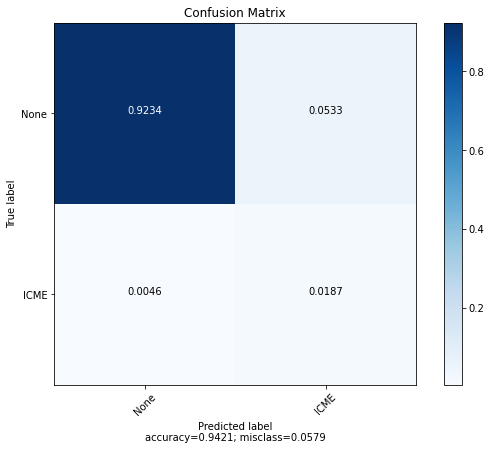

In [7]:
# create confusion matrix

from sklearn.metrics import confusion_matrix


truelabel = pp.get_label1(pred, test_clouds)

cm = confusion_matrix(truelabel, pred)

pp.plot_confusion_matrix(cm           = cm, 
                      normalize    = True,
                      target_names = ['None', 'ICME'],
                      title        = "Confusion Matrix")



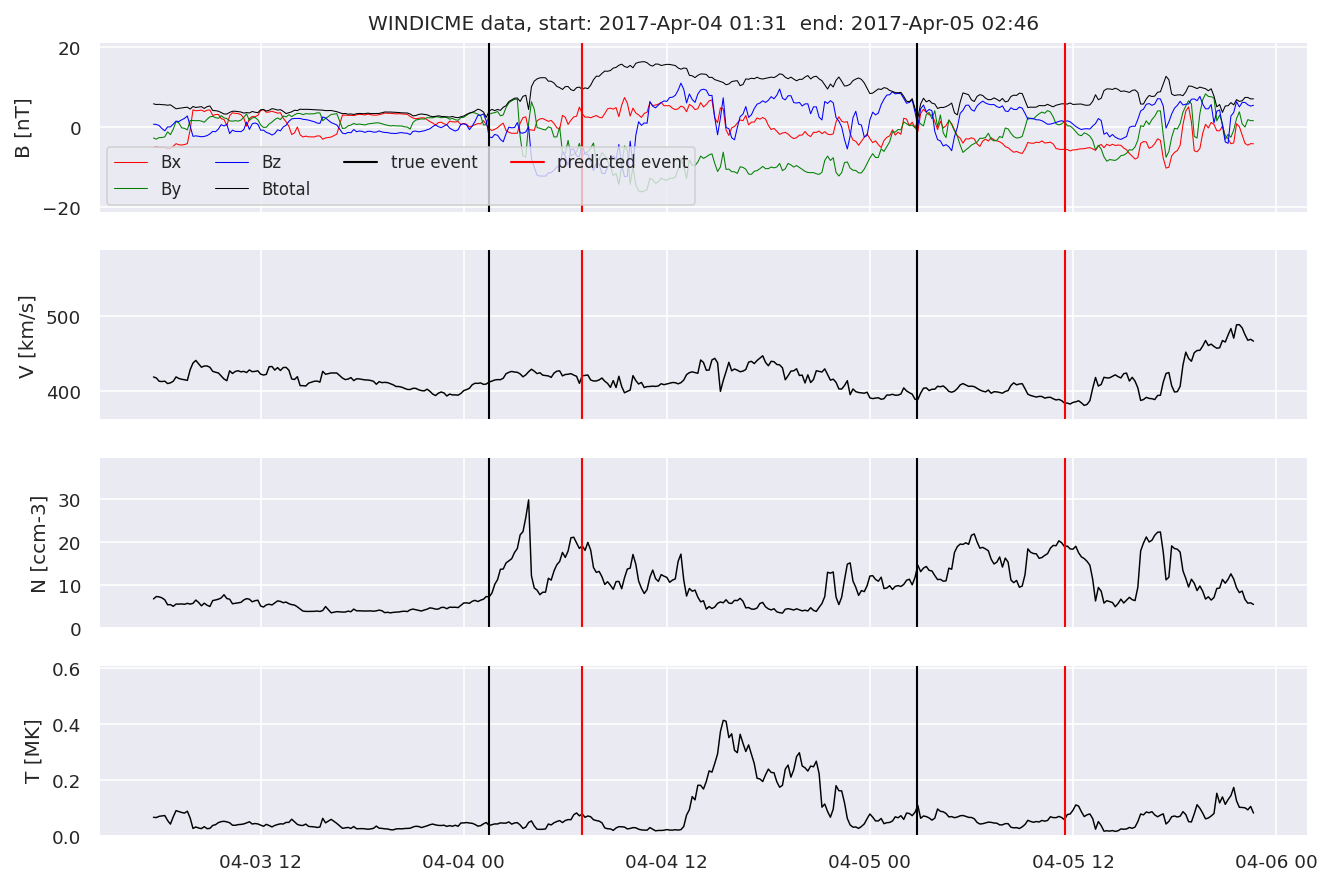

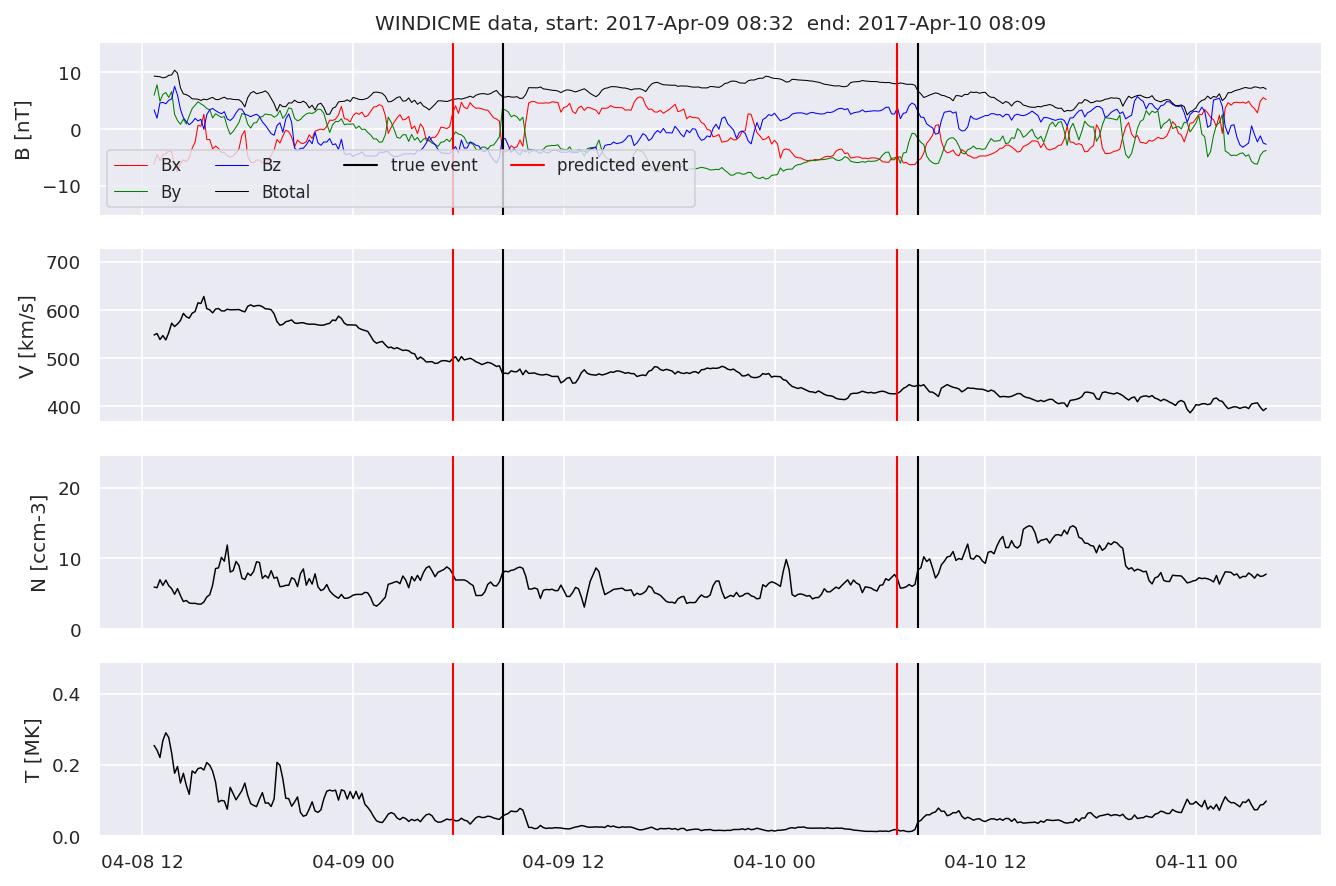

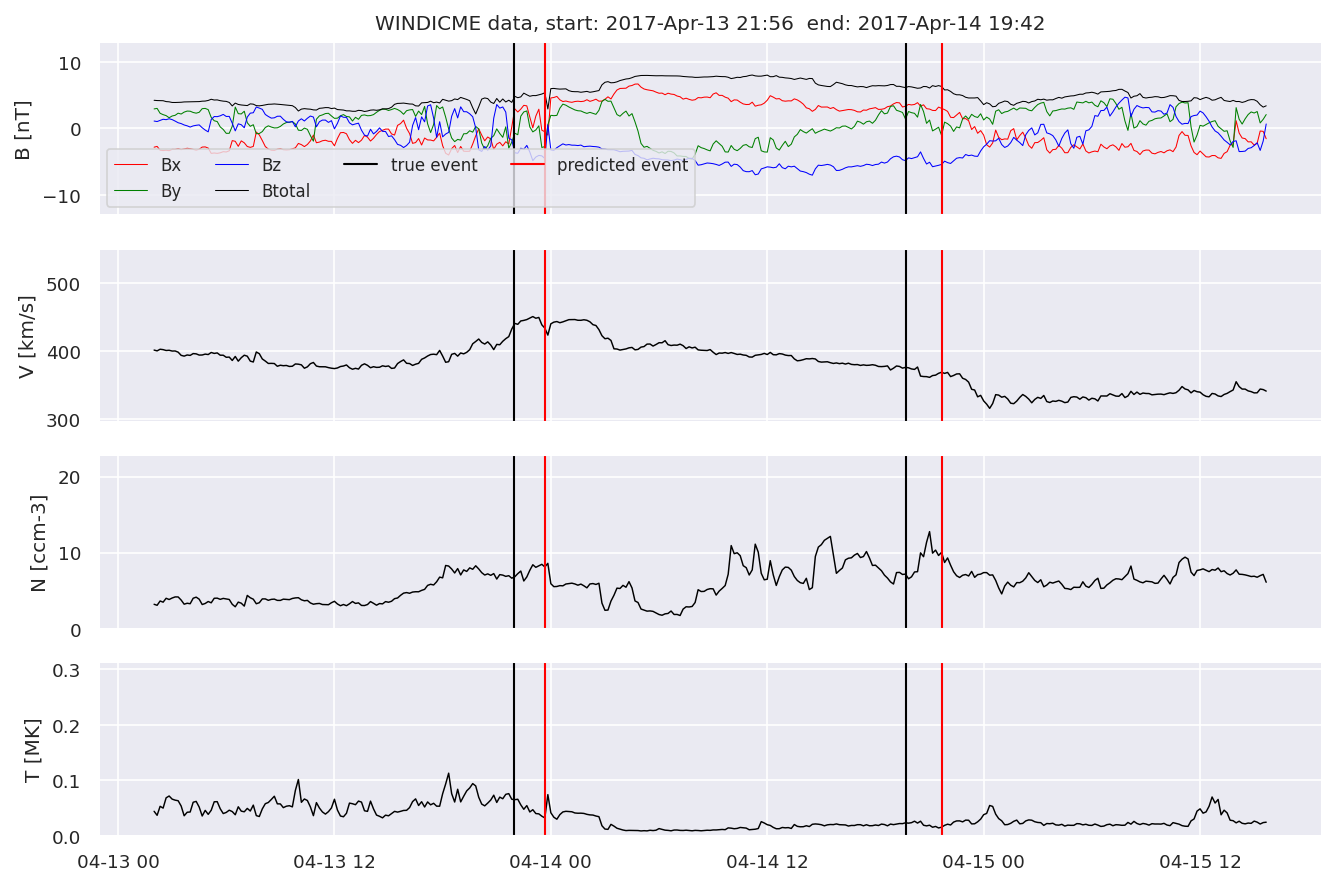

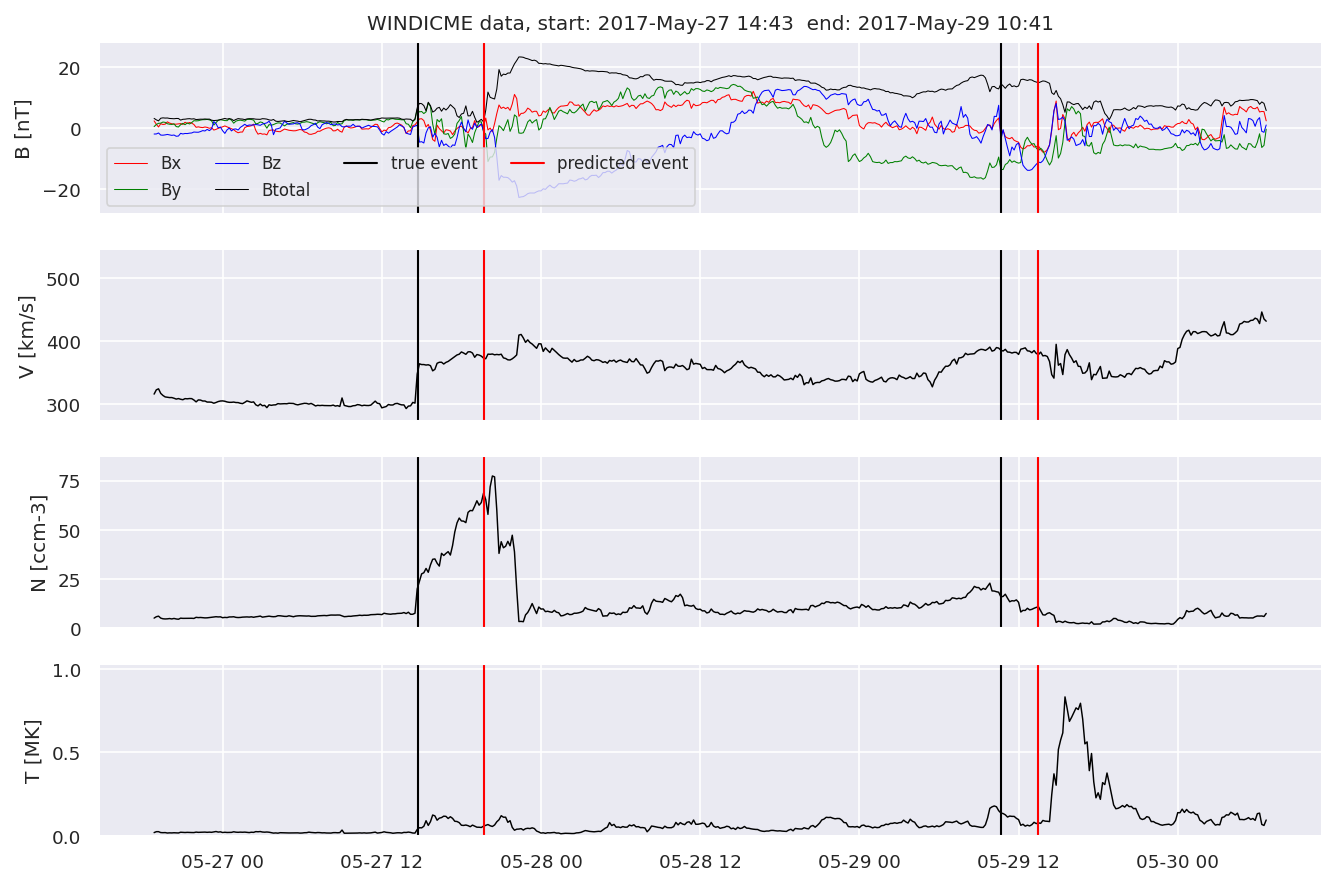

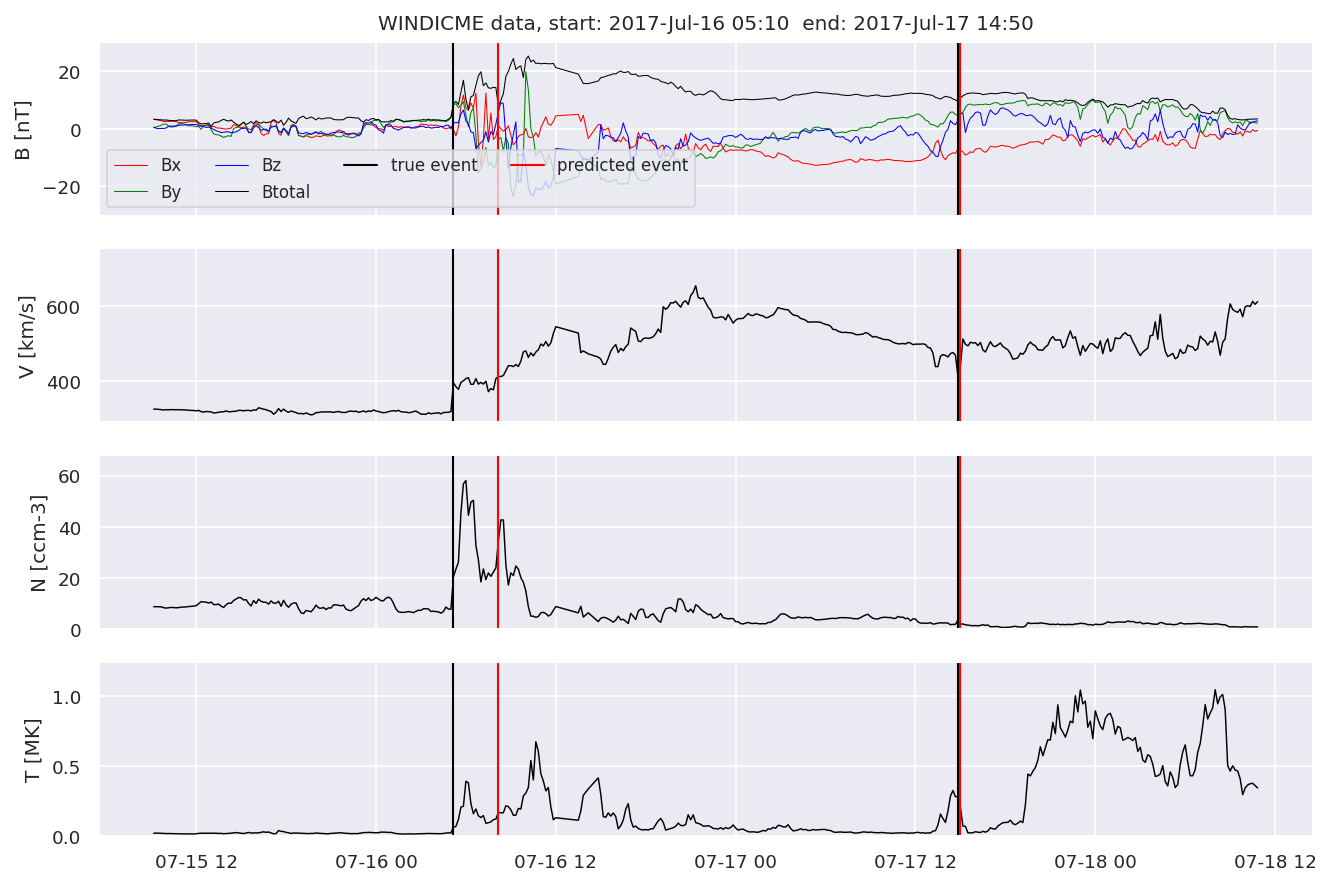

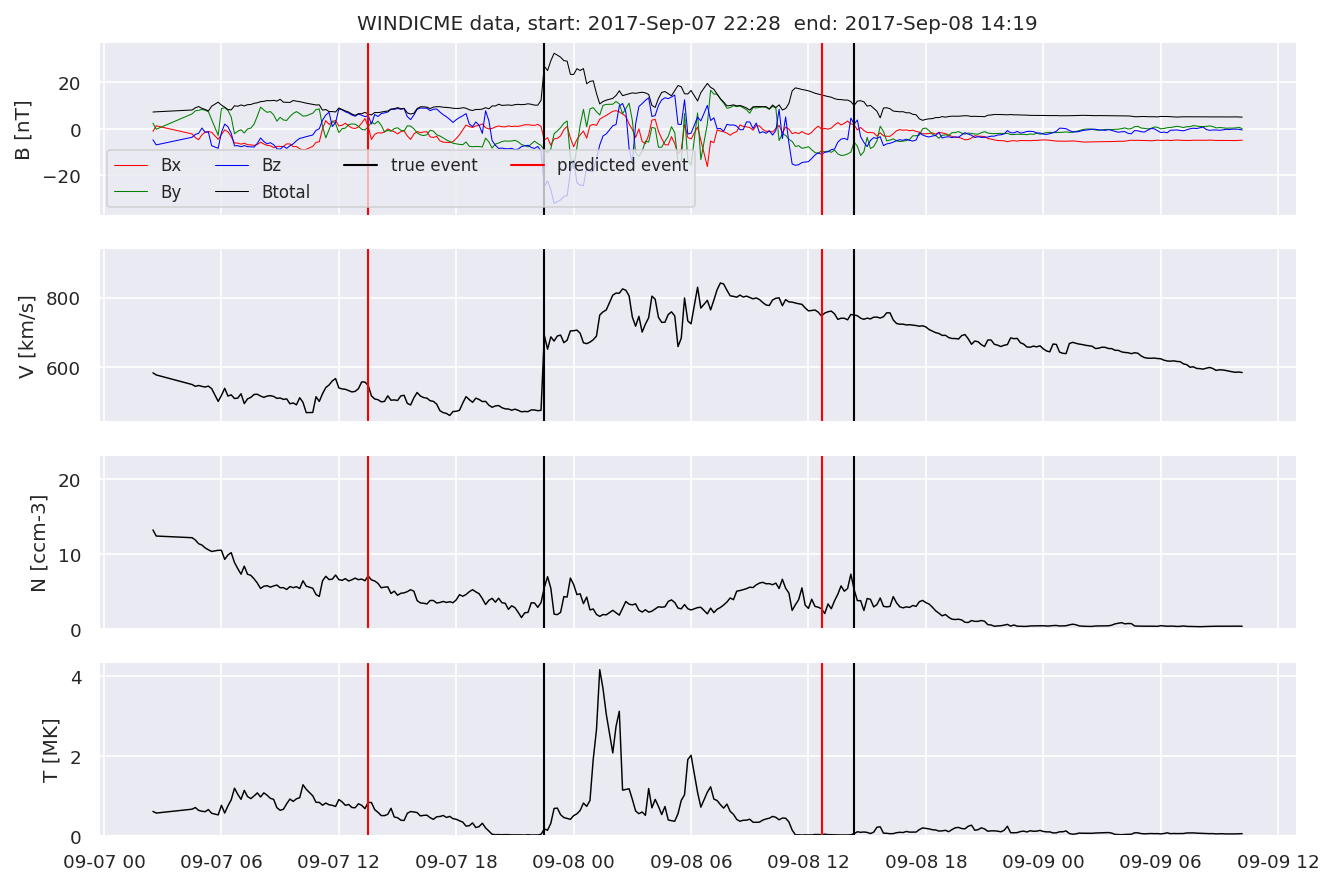

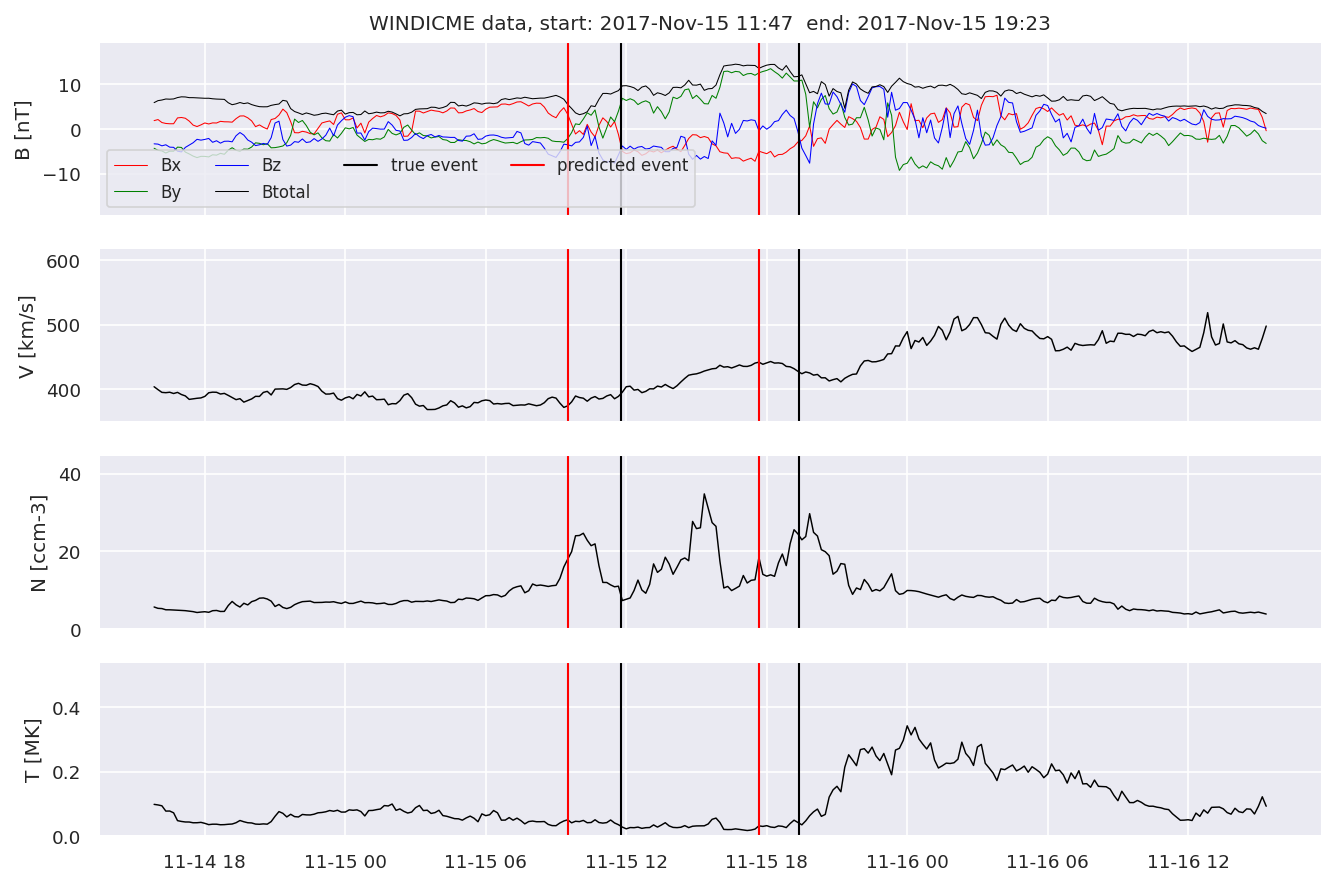

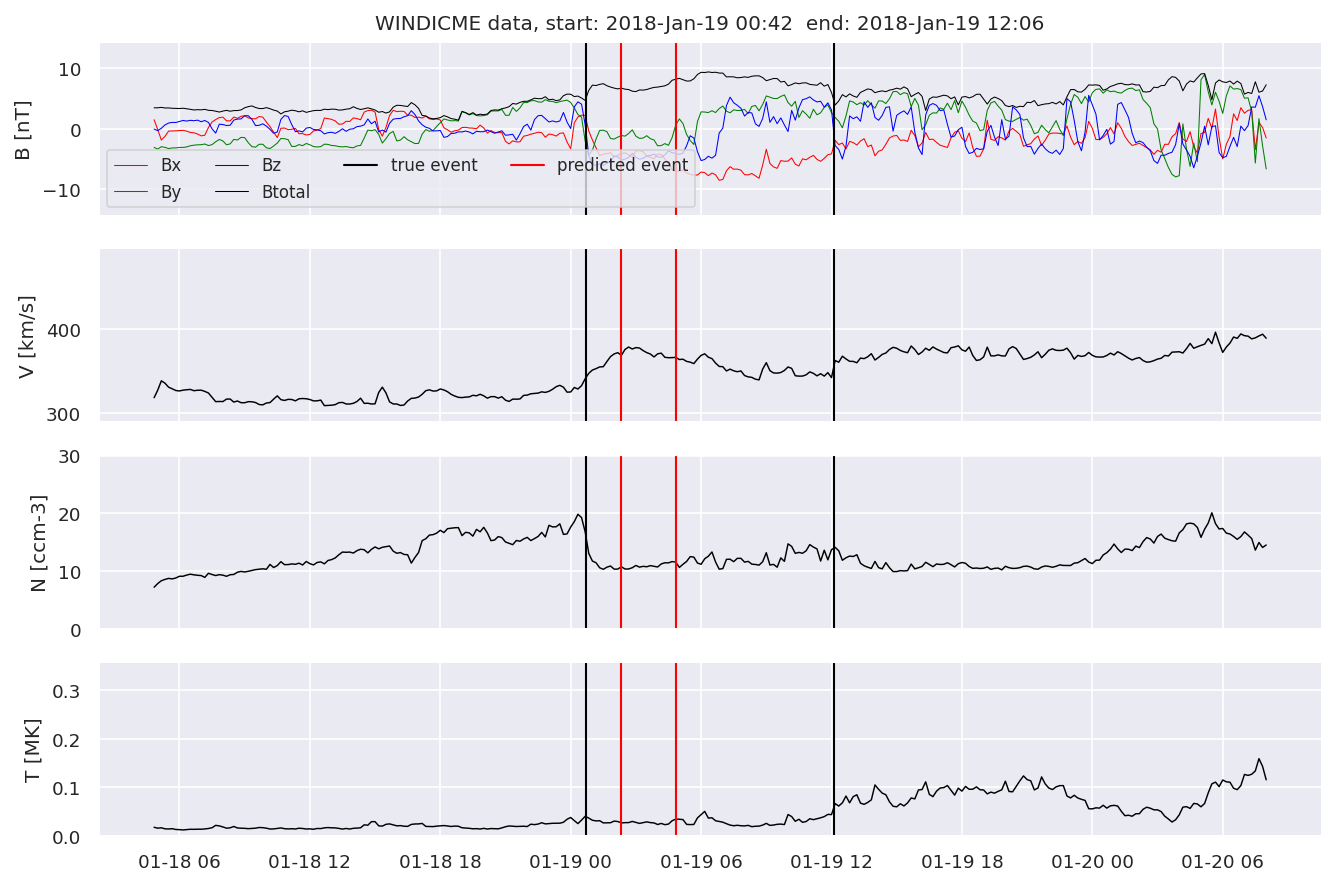

In [8]:
#plot detected ICMEs

for i in range(0, len(detected)):
    predstart = TP[i].begin
    predend = TP[i].end

    detected[i].iwfplot(data, 20, i, 'WIND', predstart, predend)